### Import required libraries

In [63]:
import pandas as pd
import numpy as np

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import requests # library to handle requests

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### Import district data


In [107]:
districts_df = pd.read_csv('./data/districts.csv')
districts_df

,district,lat,lon
0,Tuanjiehu Residential District,39.931952,116.462402
1,Maizidian Residential District,39.947085,116.472869
2,Dongzhimen Residential District,39.935732,116.439042
3,Andingmen Residential District,39.944448,116.413208
4,Dashilan Residential District,39.894292,116.390960
5,Sanlitun,39.935439,116.455070
6,Beixin residential District,39.941747,116.424027
7,Changqiao Residential District,39.934023,116.378907
8,Xinjiekou Residential District,39.941035,116.365542
9,Fensheng Residential District,39.918179,116.363393


### Plot given districts as points in Beijing
Ensure all given districts are shown on map 

In [120]:
latitude = districts_df['lat'].mean()
longitude = districts_df['lon'].mean()
data_map = folium.Map(location=[latitude, longitude], zoom_start=12)

#add markers to map
for lat, lng, label in zip(districts_df['lat'], districts_df['lon'], districts_df['district']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(data_map)  
    
data_map

### Extract district venues from Foursquare API
For each district, collect the venues contained in a 1000m radius, limit results to 100 venues
<br> Only store venue category

In [109]:
CLIENT_ID = ###Client ID
CLIENT_SECRET = ###Client Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100

In [110]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [122]:
nearby_venues = getNearbyVenues(districts_df['district'], districts_df['lat'], districts_df['lon'], radius=500)
nearby_venues.head()

Tuanjiehu Residential District
Maizidian Residential District
Dongzhimen Residential District
Andingmen Residential District
Dashilan Residential District
Sanlitun
Beixin residential District
Changqiao Residential District
Xinjiekou Residential District
Fensheng Residential District
Qianmen Residential District
Donghuamen Residential District
Namofang Residential District
Fusuijing Residential District
Xicheng
Ganjiakou Residential District
Dongcheng
Niujie Residential District
Taipingqiao Residential District
Wangjing


,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Tuanjiehu Residential District,39.931952,116.462402,眉州东坡酒楼 Meizhou Dongpo Restaurant,39.929002,116.464664,Chinese Restaurant
1,Tuanjiehu Residential District,39.931952,116.462402,Jingkelong Supermarket 京客隆团结湖店,39.930321,116.460980,Grocery Store
2,Tuanjiehu Residential District,39.931952,116.462402,潮州牛肉丸火锅,39.932662,116.458758,Chinese Restaurant
3,Tuanjiehu Residential District,39.931952,116.462402,Deli de Luxe,39.934684,116.466577,Deli / Bodega
4,Tuanjiehu Residential District,39.931952,116.462402,Pure Lotus,39.933258,116.457231,Vegetarian / Vegan Restaurant


### Transform Data
Perform onehot encoding on data so that rows are created for districts having venue category counts as columns
<br> Group rows by district and count occurences of each venue category

In [112]:
# one hot encoding
district_onehot = pd.get_dummies(nearby_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
district_onehot['District'] = nearby_venues['District'] 

# move neighborhood column to the first column
fixed_columns = [district_onehot.columns[-1]] + list(district_onehot.columns[:-1])
district_onehot = district_onehot[fixed_columns]
#scarborough_onehot.head()
district_onehot

,District,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,Bar,Bed & Breakfast,Beer Bar,...,Szechuan Restaurant,Taiwanese Restaurant,Thai Restaurant,Theater,Turkish Restaurant,Vegetarian / Vegan Restaurant,Xinjiang Restaurant,Yoga Studio,Yunnan Restaurant,Zhejiang Restaurant
0,Tuanjiehu Residential District,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Tuanjiehu Residential District,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Tuanjiehu Residential District,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Tuanjiehu Residential District,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Tuanjiehu Residential District,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,Tuanjiehu Residential District,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Tuanjiehu Residential District,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Maizidian Residential District,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Maizidian Residential District,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Maizidian Residential District,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [124]:
district_grouped = district_onehot.groupby('District').mean().reset_index()
district_grouped.head()

,District,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,Bar,Bed & Breakfast,Beer Bar,...,Szechuan Restaurant,Taiwanese Restaurant,Thai Restaurant,Theater,Turkish Restaurant,Vegetarian / Vegan Restaurant,Xinjiang Restaurant,Yoga Studio,Yunnan Restaurant,Zhejiang Restaurant
0,Andingmen Residential District,0.0,0.0,0.0,0.000000,0.0,0.0,0.090909,0.045455,0.0,...,0.0,0.0,0.0,0.0,0.0,0.136364,0.000000,0.0,0.0,0.0
1,Beixin residential District,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.040000,0.000000,0.0,0.0,0.0
2,Changqiao Residential District,0.0,0.1,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
3,Dashilan Residential District,0.0,0.0,0.0,0.000000,0.0,0.0,0.040000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
4,Dongcheng,0.0,0.0,0.0,0.111111,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.111111,0.111111,0.0,0.0,0.0


In [114]:
num_top_venues = 5

for hood in district_grouped['District']:
    print("----"+hood+"----")
    temp = district_grouped[district_grouped['District'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Andingmen Residential District----
                           venue  freq
0  Vegetarian / Vegan Restaurant  0.14
1             Chinese Restaurant  0.14
2                           Café  0.14
3                            Bar  0.09
4                    Coffee Shop  0.09


----Beixin residential District----
                 venue  freq
0   Chinese Restaurant  0.16
1   Russian Restaurant  0.12
2        Grocery Store  0.08
3          Coffee Shop  0.08
4  Japanese Restaurant  0.08


----Changqiao Residential District----
                    venue  freq
0                   Hotel   0.3
1        Department Store   0.1
2  Peking Duck Restaurant   0.1
3             Art Gallery   0.1
4           Metro Station   0.1


----Dashilan Residential District----
                    venue  freq
0  Peking Duck Restaurant  0.12
1                   Hotel  0.12
2    Fast Food Restaurant  0.12
3      Chinese Restaurant  0.12
4                  Hostel  0.08


----Dongcheng----
                           ven

In [115]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [125]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
district_venues_sorted = pd.DataFrame(columns=columns)
district_venues_sorted['District'] = district_grouped['District']

for ind in np.arange(district_grouped.shape[0]):
    district_venues_sorted.iloc[ind, 1:] = return_most_common_venues(district_grouped.iloc[ind, :], num_top_venues)

district_venues_sorted

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Andingmen Residential District,Café,Vegetarian / Vegan Restaurant,Chinese Restaurant,Coffee Shop,Bar,Hotel,French Restaurant,Buddhist Temple,Historic Site,Sandwich Place
1,Beixin residential District,Chinese Restaurant,Russian Restaurant,Hotel,Grocery Store,Coffee Shop,Japanese Restaurant,Italian Restaurant,Café,Pizza Place,Electronics Store
2,Changqiao Residential District,Hotel,Art Gallery,Peking Duck Restaurant,Metro Station,Historic Site,Chinese Restaurant,Department Store,Museum,Zhejiang Restaurant,French Restaurant
3,Dashilan Residential District,Hotel,Fast Food Restaurant,Peking Duck Restaurant,Chinese Restaurant,Hostel,Coffee Shop,Hunan Restaurant,Bar,Metro Station,Beijing Restaurant
4,Dongcheng,Hostel,Convenience Store,Asian Restaurant,Dumpling Restaurant,Hotel,Motel,Vegetarian / Vegan Restaurant,Xinjiang Restaurant,Hunan Restaurant,French Restaurant
5,Donghuamen Residential District,Hotel,Chinese Restaurant,Hotel Bar,Clothing Store,Ice Cream Shop,Pizza Place,Convenience Store,Sushi Restaurant,Fast Food Restaurant,Café
6,Dongzhimen Residential District,Chinese Restaurant,Hotpot Restaurant,Indian Restaurant,Nightclub,Speakeasy,Bar,Cocktail Bar,Dessert Shop,Pub,Pizza Place
7,Fensheng Residential District,Bookstore,Coffee Shop,BBQ Joint,Theater,Hotel,Grocery Store,Dim Sum Restaurant,Dumpling Restaurant,Electronics Store,Fast Food Restaurant
8,Fusuijing Residential District,Chinese Restaurant,Hotel,Music Store,Metro Station,Hostel,Mexican Restaurant,Beijing Restaurant,Beer Bar,Bakery,BBQ Joint
9,Ganjiakou Residential District,Metro Station,Food Truck,Zhejiang Restaurant,Grocery Store,Dessert Shop,Dim Sum Restaurant,Dumpling Restaurant,Electronics Store,Fast Food Restaurant,Food Court


## Optimization
Determine optimal number of clusters for k-means by employing the elbow method

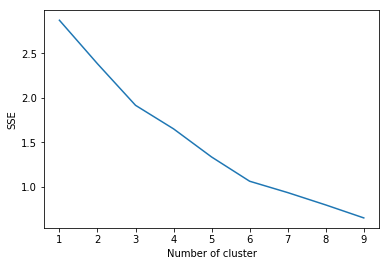

In [99]:
district_grouped_clustering = district_grouped.drop('District', 1)
district_merged = districts_df 

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=0).fit(district_grouped_clustering)
    district_merged['Cluster Labels'] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

As shown above, the optimal number of k clusters is decided on 6
<br> Perform kmeans using n=6 clusters

In [117]:
district_merged = districts_df 

# set number of clusters
kclusters = 6

district_grouped_clustering = district_grouped.drop('District', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(district_grouped_clustering)
district_merged['Cluster Labels'] = kmeans.labels_

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 5, 1, 1, 1, 1, 1, 1, 4], dtype=int32)

In [101]:
district_merged.shape

(20, 4)

In [102]:
kmeans.labels_.shape

(20,)

In [118]:


# add clustering labels
#district_merged['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
district_merged = district_merged.join(district_venues_sorted.set_index('District'), on='district')

district_merged # check the last columns!

,district,lat,lon,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Tuanjiehu Residential District,39.931952,116.462402,1,Chinese Restaurant,Vegetarian / Vegan Restaurant,Deli / Bodega,Grocery Store,Zhejiang Restaurant,Furniture / Home Store,Dessert Shop,Dim Sum Restaurant,Dumpling Restaurant,Electronics Store
1,Maizidian Residential District,39.947085,116.472869,1,Clothing Store,Coffee Shop,Pizza Place,Japanese Restaurant,Shopping Mall,Bakery,Burger Joint,Café,Chinese Restaurant,Dessert Shop
2,Dongzhimen Residential District,39.935732,116.439042,5,Chinese Restaurant,Hotpot Restaurant,Indian Restaurant,Nightclub,Speakeasy,Bar,Cocktail Bar,Dessert Shop,Pub,Pizza Place
3,Andingmen Residential District,39.944448,116.413208,1,Café,Vegetarian / Vegan Restaurant,Chinese Restaurant,Coffee Shop,Bar,Hotel,French Restaurant,Buddhist Temple,Historic Site,Sandwich Place
4,Dashilan Residential District,39.894292,116.390960,1,Hotel,Fast Food Restaurant,Peking Duck Restaurant,Chinese Restaurant,Hostel,Coffee Shop,Hunan Restaurant,Bar,Metro Station,Beijing Restaurant
5,Sanlitun,39.935439,116.455070,1,Japanese Restaurant,Vegetarian / Vegan Restaurant,Chinese Restaurant,Jazz Club,Hotel,Gym,Middle Eastern Restaurant,Peking Duck Restaurant,Persian Restaurant,Convention Center
6,Beixin residential District,39.941747,116.424027,1,Chinese Restaurant,Russian Restaurant,Hotel,Grocery Store,Coffee Shop,Japanese Restaurant,Italian Restaurant,Café,Pizza Place,Electronics Store
7,Changqiao Residential District,39.934023,116.378907,1,Hotel,Art Gallery,Peking Duck Restaurant,Metro Station,Historic Site,Chinese Restaurant,Department Store,Museum,Zhejiang Restaurant,French Restaurant
8,Xinjiekou Residential District,39.941035,116.365542,1,Chinese Restaurant,Szechuan Restaurant,Hostel,Zhejiang Restaurant,Furniture / Home Store,Dessert Shop,Dim Sum Restaurant,Dumpling Restaurant,Electronics Store,Fast Food Restaurant
9,Fensheng Residential District,39.918179,116.363393,4,Bookstore,Coffee Shop,BBQ Joint,Theater,Hotel,Grocery Store,Dim Sum Restaurant,Dumpling Restaurant,Electronics Store,Fast Food Restaurant


### Interpretation
From the table above it can be inferred that cluster no. 5 provides a good variety of of venues including several that can be viewed expat-friendly. 

#### Map clusters

In [119]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(district_merged['lat'], district_merged['lon'], district_merged['district'], district_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters